3001
Found 3002 files belonging to 3 classes.
Using 2702 files for training.
Found 3002 files belonging to 3 classes.
Using 300 files for validation.
['fruit_brownspot', 'fruit_healthy', 'fruit_woodiness']
0.0 1.0
0.003921569 1.0
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 511, 511, 3)       39        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 253, 253, 3)       84        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 126, 126, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 124, 124, 3)       84        
______________________

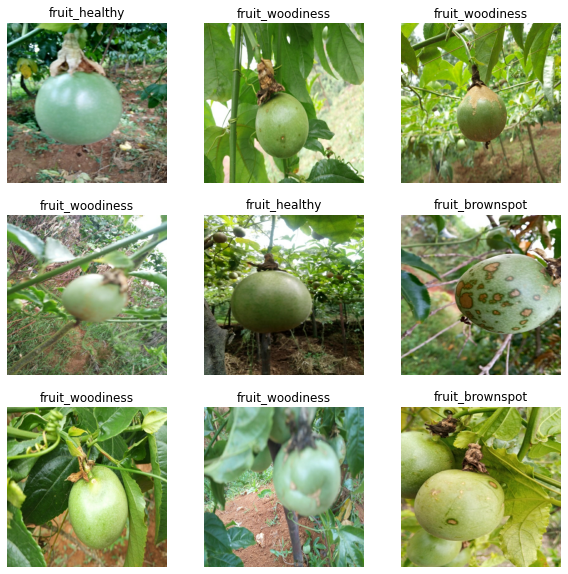

In [6]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import PIL
import PIL.Image
import numpy as np
import pathlib
import pandas as pd
import shutil
import matplotlib.pyplot as plt


data_dir = "train_images/Train_Images"

data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

imgs = list(data_dir.glob('*healthy/*'))
PIL.Image.open(str(imgs[0]))

train = pd.read_csv('Train.csv')

batch_size = 100
img_height = 512
img_width = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)




val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# for image_batch, labels_batch in train_ds:
#   # print(image_batch.shape)
#   # print(labels_batch.shape)
#   break


normalization_layer = tf.keras.layers.Rescaling(1./255)

normalizedTrain_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalizedTrain_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


normalizedVal_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalizedVal_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

AUTOTUNE = tf.data.AUTOTUNE

# print(normalizedTrain_ds)
# print(normalizedVal_ds)

normalizedTrain_ds = normalizedTrain_ds.shuffle(image_count, reshuffle_each_iteration=True)
normalizedVal_ds = normalizedVal_ds.shuffle(int(image_count*0.15), reshuffle_each_iteration=True)

# print(normalizedTrain_ds)
# print(normalizedVal_ds)

normalizedTrain_ds = normalizedTrain_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalizedVal_ds = normalizedVal_ds.cache().prefetch(buffer_size=AUTOTUNE)

# print(normalizedTrain_ds)
# print(normalizedVal_ds)


num_classes = len(class_names)


model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(3, 2, strides=1, activation='relu', input_shape=(512,512,3)),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(3, 3, strides=1, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(3, 3, strides=1, activation='relu'),
  tf.keras.layers.MaxPool2D(),
  # tf.keras.layers.Conv2D(3, 3, strides=1, activation='relu'),
  # tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)

])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
model.summary()

history = model.fit(
  normalizedTrain_ds,
  validation_data=normalizedVal_ds,
  batch_size=100,
  epochs=10
)
